In [35]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), os.pardir))

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse.linalg import norm
from io_utils import load_models, load_matrices_from_dir

In [37]:
matrix = "ct20stif"
# matrix = "cbuckle"
df = pd.read_csv(f"data/{matrix}_1000.csv")
errorfree_iterations = df["errorfree_iterations"][0]  # all the same
n_rows = df["n_rows"][0]  # all the same
df.head()

,mat_name,errorfree_iterations,tol,maxiter,error_pos,error_iter,solve_iterations,final_relres,did_converge,realtime_s,pos_2norm,n_rows,slowdown
0,ct20stif.mat,364,0.000001,36400,19672,131,1536,8.620662e-07,True,3.288570,3.520775e+06,52329,4.219780
1,ct20stif.mat,364,0.000001,36400,22273,70,915,9.752646e-07,True,1.937954,1.004867e+06,52329,2.513736
2,ct20stif.mat,364,0.000001,36400,34752,349,354,7.988055e-07,True,0.752107,2.162972e+06,52329,0.972527
3,ct20stif.mat,364,0.000001,36400,21828,256,36399,1.778341e-06,False,78.816517,3.266234e+07,52329,99.997253
4,ct20stif.mat,364,0.000001,36400,25940,361,366,6.946808e-07,True,0.805048,6.260465e+05,52329,1.005495


In [38]:
chosen_models = {
    "bcsstk18": "RandomForestRegressor",
    "cbuckle": "KNeighborsRegressor",
    "ct20stif": "XGBRegressor"
}
model_path = f"./models/{matrix}/best_{chosen_models[matrix]}.pkl"
model = load_models([model_path])[0]
model

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('xgbregressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.05561218818274389, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=6, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=1000, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [39]:
X = df[["error_iter", "pos_2norm"]].to_numpy()
df["prot_score"] = model.predict(X)
df.head()

,mat_name,errorfree_iterations,tol,maxiter,error_pos,error_iter,solve_iterations,final_relres,did_converge,realtime_s,pos_2norm,n_rows,slowdown,prot_score
0,ct20stif.mat,364,0.000001,36400,19672,131,1536,8.620662e-07,True,3.288570,3.520775e+06,52329,4.219780,6.374251
1,ct20stif.mat,364,0.000001,36400,22273,70,915,9.752646e-07,True,1.937954,1.004867e+06,52329,2.513736,2.869815
2,ct20stif.mat,364,0.000001,36400,34752,349,354,7.988055e-07,True,0.752107,2.162972e+06,52329,0.972527,0.881503
3,ct20stif.mat,364,0.000001,36400,21828,256,36399,1.778341e-06,False,78.816517,3.266234e+07,52329,99.997253,21.832335
4,ct20stif.mat,364,0.000001,36400,25940,361,366,6.946808e-07,True,0.805048,6.260465e+05,52329,1.005495,0.958678


In [40]:
mats = load_matrices_from_dir("../matrices/raw", subset=[matrix])
mat = list(mats.values())[0]
mat

<52329x52329 sparse matrix of type '<class 'numpy.float64'>'
	with 2600295 stored elements in Compressed Sparse Column format>

In [41]:
pos_2norms = {pos: norm(mat.getrow(pos)) for pos in range(mat.shape[0])}
iter_norm_pairs = np.array([[i, pos_2norms[pos], pos] for pos in range(mat.shape[0])
                            for i in range(errorfree_iterations)])
df_preds = pd.DataFrame(iter_norm_pairs, columns=["i", "2norm", "rowid"])
df_preds["output"] = model.predict(df_preds[["i", "2norm"]].to_numpy())
df_preds_piv = df_preds.pivot(index=["2norm", "rowid"], columns="i", values="output")
prot_scores = df_preds_piv.to_numpy().T
df_preds_piv.head()

,i,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,354.0,355.0,356.0,357.0,358.0,359.0,360.0,361.0,362.0,363.0
2norm,rowid,,,,,,,,,,,,,,,,,,,,,
1473.855423,27832.0,0.352926,0.352926,0.648519,2.316674,2.316674,0.10162,0.622984,0.563497,1.507696,1.507696,...,0.923043,0.932125,0.932125,0.966129,0.966129,0.989485,0.989485,0.873178,0.877503,0.877503
3762.092180,16273.0,0.352926,0.352926,0.648519,2.316674,2.316674,0.10162,0.622984,0.563497,1.507696,1.507696,...,0.923043,0.932125,0.932125,0.966129,0.966129,0.989485,0.989485,0.873178,0.877503,0.877503
4986.796757,38393.0,0.352926,0.352926,0.648519,2.316674,2.316674,0.10162,0.622984,0.563497,1.507696,1.507696,...,0.923043,0.932125,0.932125,0.966129,0.966129,0.989485,0.989485,0.873178,0.877503,0.877503
5135.358984,27826.0,0.352926,0.352926,0.648519,2.316674,2.316674,0.10162,0.622984,0.563497,1.507696,1.507696,...,0.923043,0.932125,0.932125,0.966129,0.966129,0.989485,0.989485,0.873178,0.877503,0.877503
5299.514799,7308.0,0.352926,0.352926,0.648519,2.316674,2.316674,0.10162,0.622984,0.563497,1.507696,1.507696,...,0.923043,0.932125,0.932125,0.966129,0.966129,0.989485,0.989485,0.873178,0.877503,0.877503


In [42]:
ps = list(np.arange(1 / 98, 1.01, 0.01))
percentages = np.arange(0.01, 1.0, 0.01)
nonerror_runs_by_p = {p: int((len(df) / p) - len(df)) for p in ps}
max_nonerror_runs = int((len(df) / min(ps)) - len(df))
solve_iterations = np.append(df["solve_iterations"], [errorfree_iterations] * max_nonerror_runs)
slowdowns = np.append(df["slowdown"], [1] * max_nonerror_runs)
errorfree_op_count = errorfree_iterations * n_rows

In [43]:
def compute_overheads(error_iterations, n_protections):
    return ((error_iterations * n_rows + n_protections) - errorfree_op_count) / errorfree_op_count

def protect(error_iterations, protections):
    return np.vectorize(lambda i: error_iterations[i] if not protections[i]
                        else errorfree_iterations)(range(len(error_iterations)))

def make_p_overhead_dataframe(ohs_by_p):
    return pd.concat([pd.DataFrame({"p": [ps[i]] * len(os), "overhead": os})
                         for i, os in enumerate(ohs_by_p)], ignore_index=True)

In [44]:
nonprot_overheads_by_p = []

for p in ps:
    # need to pad dataset to add non-error runs
    n_nonerror_runs = nonerror_runs_by_p[p]
    data_size = n_nonerror_runs + len(df)

    nonprot_overheads = compute_overheads(solve_iterations[:data_size], 0)
    nonprot_overheads_by_p.append(nonprot_overheads)

nonprot_df = make_p_overhead_dataframe(nonprot_overheads_by_p)

In [45]:
prot_overheads_by_p = []

for p in ps:
    # need to pad dataset to add non-error runs
    n_nonerror_runs = nonerror_runs_by_p[p]
    data_size = n_nonerror_runs + len(df)
    
    # for the purpose of choosing solve_iterations or errorfree_iterations, did_protect will
    # always be False for nonerror runs, but this is fine because n_protections is computed
    # later for the purposes of calculating overhead
    protections = np.append(df["prot_score"] > (1 + (1 / p)), [False] * n_nonerror_runs)

    prot_iterations = protect(solve_iterations[:data_size], protections)
    n_protections = (prot_scores > (1 + (1 / p))).sum()

    prot_overheads = compute_overheads(prot_iterations, n_protections)
    prot_overheads_by_p.append(prot_overheads)

prot_df = make_p_overhead_dataframe(prot_overheads_by_p)

In [46]:
random_overheads = []
for perc in percentages:
    protections = np.random.rand(len(df)) < perc
    prot_iterations = protect(solve_iterations[:len(df)], protections)
    n_protections = int(errorfree_iterations * n_rows * perc)
    prot_overheads = compute_overheads(prot_iterations, n_protections)
    random_overheads.append(prot_overheads.mean())
    
best_random_percentage = percentages[np.argmin(random_overheads)]
rand_overheads_by_p = []

for p in ps:
    # need to pad dataset to add non-error runs
    n_nonerror_runs = nonerror_runs_by_p[p]
    data_size = n_nonerror_runs + len(df)
    
    protections = np.random.rand(data_size) < best_random_percentage

    prot_iterations = protect(solve_iterations[:data_size], protections)
    n_protections = int(errorfree_iterations * n_rows * best_random_percentage)
    
    prot_overheads = compute_overheads(prot_iterations, n_protections)
    rand_overheads_by_p.append(prot_overheads)

rand_df = make_p_overhead_dataframe(rand_overheads_by_p)

In [47]:
r2ns = np.array(list(pos_2norms.values()))
r2n_overheads = []
for perc in percentages:
    cutoff = np.quantile(r2ns, 1 - perc)
    protections = df["pos_2norm"] >= cutoff
    prot_iterations = protect(solve_iterations[:len(df)], protections)
    n_protections = errorfree_iterations * (r2ns >= cutoff).sum()
    prot_overheads = compute_overheads(prot_iterations, n_protections)
    r2n_overheads.append(prot_overheads.mean())

best_r2n_percentage = percentages[np.argmin(r2n_overheads)]
cutoff = np.quantile(r2ns, 1 - best_r2n_percentage)
r2n_overheads_by_p = []

for p in ps:
    # need to pad dataset to add non-error runs
    n_nonerror_runs = nonerror_runs_by_p[p]
    data_size = n_nonerror_runs + len(df)

    protections = np.append(df["pos_2norm"] >= cutoff, [False] * n_nonerror_runs)

    prot_iterations = protect(solve_iterations[:data_size], protections)
    n_protections = errorfree_iterations * (r2ns >= cutoff).sum()
    
    prot_overheads = compute_overheads(prot_iterations, n_protections)
    r2n_overheads_by_p.append(prot_overheads)

r2n_df = make_p_overhead_dataframe(r2n_overheads_by_p)

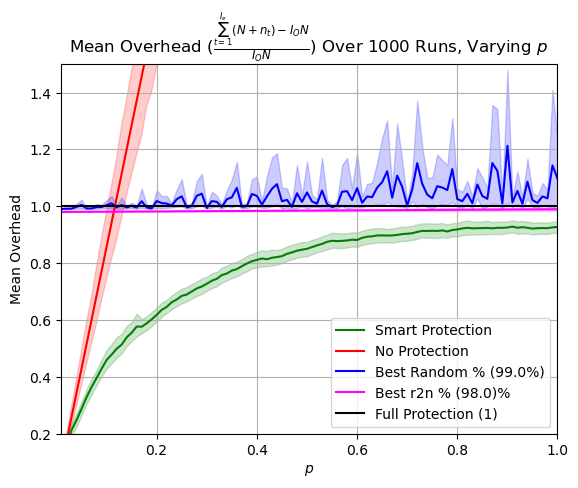

In [48]:
sns.lineplot(prot_df, x="p", y="overhead",
         label="Smart Protection", c="green")
sns.lineplot(nonprot_df, x="p", y="overhead",
             label="No Protection", c="red")
sns.lineplot(rand_df, x="p", y="overhead",
             label=f"Best Random % ({best_random_percentage * 100}%)", c="blue")
sns.lineplot(r2n_df, x="p", y="overhead",
             label=f"Best r2n % ({best_r2n_percentage * 100})%", c="magenta")
plt.plot(ps, [1] * len(ps), label="Full Protection (1)", c="black")

plt.xlabel("$p$")
plt.ylabel("Mean Overhead")
overhead_formula = r"$ \frac{\sum_{t=1}^{I_e}(N + n_t) - I_ON}{I_ON} $"
plt.title(f"Mean Overhead ({overhead_formula}) Over 1000 Runs, Varying $p$ ")
plt.legend()
plt.grid()
plt.xlim(0.01, 1)
plt.ylim(0.2, 1.5)
plt.savefig(f"./figures/{matrix}/mean_overheads.png")
plt.show()

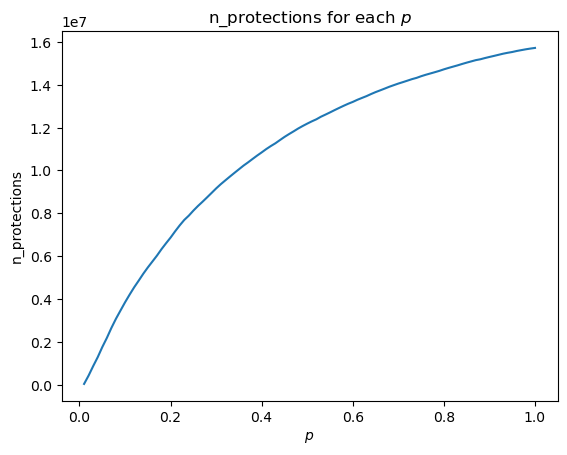

In [49]:
n_prots_per_p = []

for p in ps:
    protections = prot_scores > (1 + (1 / p))
    n_prots_per_p.append(protections.sum())

s = pd.Series(n_prots_per_p)
plt.plot(ps, s)
plt.title("n_protections for each $p$")
plt.xlabel("$p$")
plt.ylabel("n_protections")
plt.show()